# Import necessary library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as smt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import torch
import torch.nn as nn
import warnings
import random
import os
import warnings
warnings.filterwarnings("ignore")

## Read and Pre-process data

In [2]:
# Try reading data from local, if not possible, read from google drive
def getfile(location_pair,**kwargs): 
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out = pd.read_csv(loc,**kwargs)
    return out


fname=("Local_Area_Unemployment_Statistics__LAUS_.csv","https://drive.google.com/file/d/1xoDHEKiN-y4QyZNET8SdlVRSsgW_7TLy/view?usp=sharing")
raw_data=getfile(fname)
raw_data.head()

local file not found; accessing Google Drive


,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate
0,State,California,01/01/1976,1976,January,N,Final,9672362,8668016,1004346,0.104
1,State,California,01/01/1976,1976,January,Y,Final,9774280,8875685,898595,0.092
2,County,Los Angeles County,01/01/1976,1976,January,N,Final,3364151,3040058,324093,0.096
3,County,Los Angeles County,01/01/1976,1976,January,Y,Final,3381856,3081806,300050,0.089
4,Metropolitan Area,Los Angeles-Long Beach-Glendale MD,01/01/1976,1976,January,N,Final,3364151,3040058,324093,0.096


In [3]:
raw_data['Date']= pd.to_datetime(raw_data['Date'])
raw_data['ts'] = raw_data.Date.values.astype(np.int64) # convert datetime to pandas timestamps
raw_data['Employment Rate']=raw_data['Employment ']/raw_data['Labor Force']
raw_data.head()

,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate,ts,Employment Rate
0,State,California,1976-01-01,1976,January,N,Final,9672362,8668016,1004346,0.104,189302400000000000,0.896163
1,State,California,1976-01-01,1976,January,Y,Final,9774280,8875685,898595,0.092,189302400000000000,0.908065
2,County,Los Angeles County,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.096,189302400000000000,0.903663
3,County,Los Angeles County,1976-01-01,1976,January,Y,Final,3381856,3081806,300050,0.089,189302400000000000,0.911277
4,Metropolitan Area,Los Angeles-Long Beach-Glendale MD,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.096,189302400000000000,0.903663


In [4]:
raw_data.columns = ['Area Type', 'Area Name', 'Date', 'Year', 'Month',
       'Seasonally Adjusted (Y/N)', 'Status (Preliminary / Final)',
       'Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate','ts','Employment Rate']
subData_County = raw_data.loc[(raw_data['Area Type']=='County')]
subData_State = raw_data.loc[(raw_data['Area Type']=='State')]

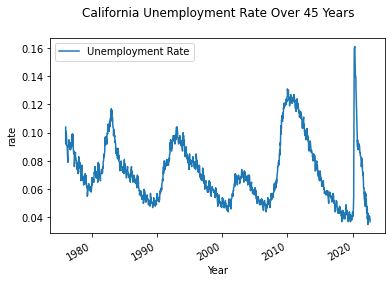

In [5]:
graphPlotter = subData_State[['Date','Unemployment Rate']]
graphPlotter.set_index(["Date"], inplace=True)
graphPlotter.plot(title="California Unemployment Rate Over 45 Years\n", ylabel="rate", xlabel="Year")

In [6]:
subData_State.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122 entries, 0 to 178345
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Area Type                     1122 non-null   object        
 1   Area Name                     1122 non-null   object        
 2   Date                          1122 non-null   datetime64[ns]
 3   Year                          1122 non-null   int64         
 4   Month                         1122 non-null   object        
 5   Seasonally Adjusted (Y/N)     1122 non-null   object        
 6   Status (Preliminary / Final)  1122 non-null   object        
 7   Labor Force                   1122 non-null   int64         
 8   Employment                    1122 non-null   int64         
 9   Unemployment                  1122 non-null   int64         
 10  Unemployment Rate             1122 non-null   float64       
 11  ts                          

In [7]:
graphPlotter.head()

,Unemployment Rate
Date,
1976-01-01,0.104
1976-01-01,0.092
1977-01-01,0.099
1977-01-01,0.092
1978-01-01,0.083


# Prepare data for model and perform train and test split

In [8]:
model_data = graphPlotter.reset_index()['Unemployment Rate']
model_data.head()

0    0.104
1    0.092
2    0.099
3    0.092
4    0.083
Name: Unemployment Rate, dtype: float64

In [9]:
# normalize the data
scaler=MinMaxScaler(feature_range=(0,1))
model_data_normalized=scaler.fit_transform(np.array(model_data).reshape(-1,1))

In [10]:
training_size=int(len(model_data_normalized)*0.65)
test_size=len(model_data_normalized)-training_size
train_data,test_data=model_data_normalized[0:training_size,:],model_data_normalized[training_size:len(model_data_normalized),:1]
print(training_size,test_size)

729 393


In [11]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
print(X_train.shape, y_train.shape)
print(X_test.shape, ytest.shape)

(628, 100) (628,)
(292, 100) (292,)


In [13]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# Model

In [14]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=45,batch_size=16,verbose=1)

Epoch 1/45
40/40 [==============================] - 14s 206ms/step - loss: 0.0420 - val_loss: 0.0294
Epoch 2/45
40/40 [==============================] - 6s 146ms/step - loss: 0.0324 - val_loss: 0.0241
Epoch 3/45
40/40 [==============================] - 6s 145ms/step - loss: 0.0289 - val_loss: 0.0197
Epoch 4/45
40/40 [==============================] - 6s 161ms/step - loss: 0.0266 - val_loss: 0.0176
Epoch 5/45
40/40 [==============================] - 6s 145ms/step - loss: 0.0236 - val_loss: 0.0159
Epoch 6/45
40/40 [==============================] - 6s 151ms/step - loss: 0.0223 - val_loss: 0.0153
Epoch 7/45
40/40 [==============================] - 7s 172ms/step - loss: 0.0224 - val_loss: 0.0155
Epoch 8/45
40/40 [==============================] - 6s 162ms/step - loss: 0.0197 - val_loss: 0.0133
Epoch 9/45
40/40 [==============================] - 6s 161ms/step - loss: 0.0185 - val_loss: 0.0115
Epoch 10/45
40/40 [==============================] - 6s 147ms/step - loss: 0.0173 - val_loss: 0.010

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

10/10 [==============================] - 0s 36ms/step


In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)


In [ ]:
ytest = scaler.inverse_transform(np.array(ytest).reshape(-1,1))

In [ ]:
model.to_pickle('final_model.pkl')

# Understanding performance metrics

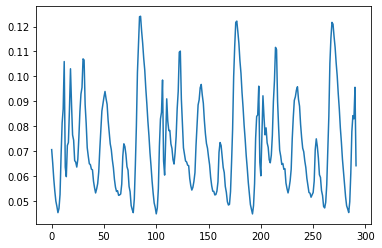

In [ ]:
plt.plot(test_predict)

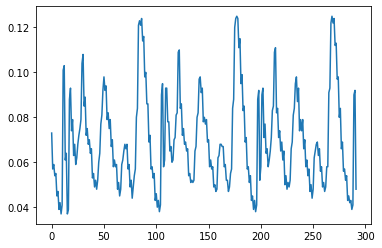

In [ ]:
plt.plot(ytest)

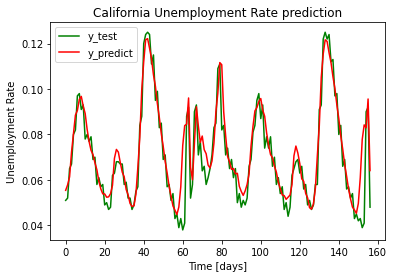

In [ ]:
plt.plot(ytest[135:], label="y_test", color='green')
plt.plot(test_predict[135:], label="y_predict", color='red')
 
plt.title('California Unemployment Rate prediction')
plt.xlabel('Time [days]')
plt.ylabel('Unemployment Rate')
plt.legend(loc='best')
 
plt.show();

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.27943896329714807

In [ ]:
### Test Data RMSE 
math.sqrt(mean_squared_error(ytest,test_predict))

0.009642279000974543